**代码仓库：** https://github.com/arcsinY/DM_Project3
### 1. 数据集分析
使用[Video Game Sales](https://www.kaggle.com/gregorut/videogamesales)数据集，这是一个电子游戏销售数据集，包括16598条数据和11个属性。
- Rank，销售量排名
- Name，游戏名称
- Platform，游戏平台
- Year，发布年份
- Genre，游戏类型
- Publisher，发行商
- NA_Sales，北美销售量（单位：百万）
- EU_Sales，欧洲销售量
- JP_Sales，日本销售量
- Other_Sales，其它地区销售量
- Global_Sales，全球总销量

#### 1.1 数据预处理
Name属性有重复值，因此需要先把重复的项目合并到一起。对于缺失值，使用删除的处理办法，将一条数据删除。处理后的数据重新按照全球销量排序

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from catboost import CatBoostRegressor
import math as math
%matplotlib inline

In [109]:
data = pd.read_csv('vgsales.csv')
# 去重
name2id = {}
for i in range(len(data)):
    if data.loc[i, 'Name'] in name2id:
        id = name2id[data.loc[i, 'Name']]
        data.loc[id, 'NA_Sales'] += data.loc[i, 'NA_Sales']
        data.loc[id, 'JP_Sales'] += data.loc[i, 'JP_Sales']
        data.loc[id, 'EU_Sales'] += data.loc[i, 'EU_Sales']
        data.loc[id, 'Other_Sales'] += data.loc[i, 'Other_Sales']
        data.loc[id, 'Global_Sales'] += data.loc[i, 'Global_Sales']
    else:
        name2id[data.loc[i, 'Name']] = i

data.drop_duplicates(subset = ['Name'], keep = 'first', inplace = True)
data.sort_values(by = 'Global_Sales')
data.reset_index(drop=True, inplace = True)

# 缺失值
for i in range(len(data)):
    for j in data.columns:
        if pd.isnull(data.loc[i, j]):
            data.drop(i, inplace = True)
            break
data.reset_index(drop=True, inplace = True)
for i in range(len(data)):
    data.loc[i, 'Rank'] = int(i + 1)
print(data)

        Rank                                               Name Platform  ...  JP_Sales Other_Sales Global_Sales
0          1                                         Wii Sports      Wii  ...      3.77        8.46        82.74
1          2                                  Super Mario Bros.      NES  ...      6.96        0.99        45.31
2          3                                     Mario Kart Wii      Wii  ...      3.79        3.31        35.82
3          4                                  Wii Sports Resort      Wii  ...      3.28        2.96        33.00
4          5                           Pokemon Red/Pokemon Blue       GB  ...     10.22        1.00        31.37
...      ...                                                ...      ...  ...       ...         ...          ...
11288  11289  Chou Ezaru wa Akai Hana: Koi wa Tsuki ni Shiru...      PSV  ...      0.01        0.00         0.01
11289  11290  Eiyuu Densetsu: Sora no Kiseki Material Collec...      PSP  ...      0.01        0

去重、删除缺失值之后得到11293条数据。

#### 1.2 属性的统计信息与可视化
首先计算5个数值属性的皮尔逊相关系数，并绘制热图

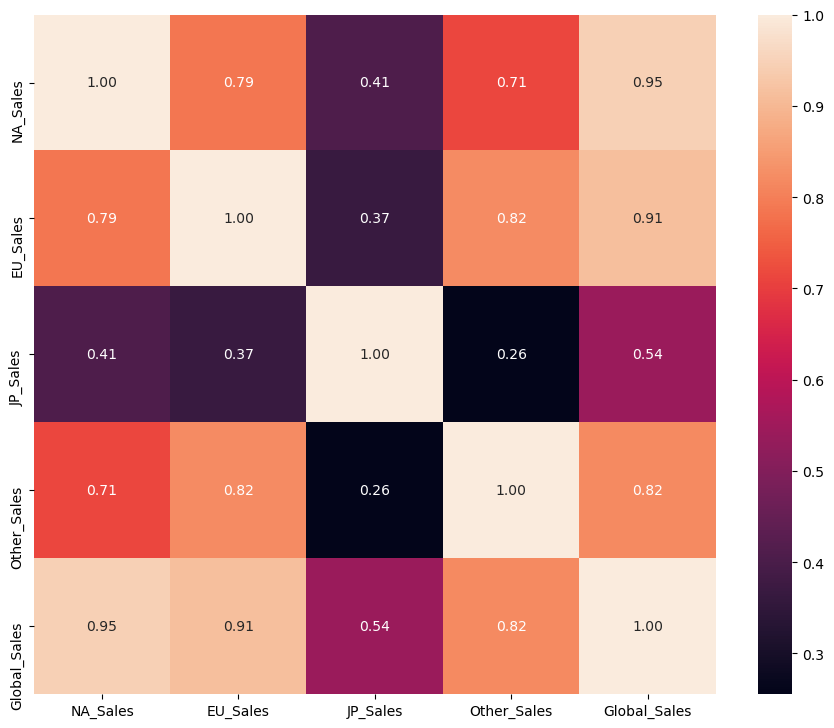

In [110]:
# 相关系数
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = data.drop(['Rank', 'Year'], axis = 1).corr(), annot = True, fmt = ".2f")
plt.show()  

可以看出，与全球销量最相关的是北美销量和欧洲销量。同时，北美销量、欧洲销量和其它地区销量之间相关性比较高。

下面给出各个属性的数据描述和可视化结果。首先是Platform

Wii 928
NES 90
GB 84
DS 1781
X360 543
PS3 696
PS2 1831
SNES 229
GBA 588
3DS 390
PS4 241
N64 245
PS 1117
XB 268
PC 487
2600 108
PSP 899
GC 166
WiiU 55
GEN 23
XOne 30
DC 43
SAT 148
PSV 277
SCD 6
WS 4
NG 9
TG16 2
3DO 3
GG 1
PCFX 1


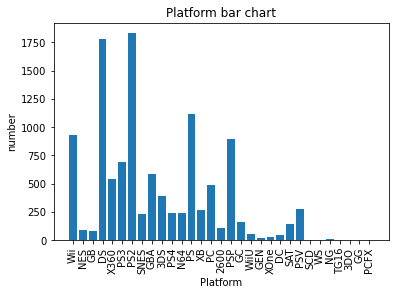

In [111]:
# 数据描述
# 统计标称属性attr各个类别出现频数，返回dict{类别：频数}
def nominal_attr_statistic(data, attr):
    res = {}
    for i in data[attr]:
        if pd.isnull(i):
            continue
        if i in res:
            res[i] += 1
        else:
            res[i] = 1
    return res
# 标称属性柱状图绘制
def nominal_barchart(dict, attr, bound = 0):
    key = []
    value = []
    # 找出满足要求的key和value
    key = []
    value = []
    for k,v in dict.items():
        if v >= bound:
            key.append(k)
            value.append(v)
    key = np.array(key)
    value = np.array(value)
    # 绘制图像
    fig, ax = plt.subplots()
    bar_chart = ax.bar(key, value)
    ax.set_title(attr+' bar chart')
    ax.set_ylabel('number')
    ax.set_xlabel(attr)
    plt.xticks(rotation=90)

platform = nominal_attr_statistic(data, 'Platform')
for k, v in platform.items():
    print(str(k) + ' ' + str(v))
nominal_barchart(platform, 'Platform')

可以看出，在所有游戏平台中，Wii，DS，PS，PS2，PSP占据数量远大于其它平台。

下面统计Genre属性的出现频率并可视化。

Sports 1359
Platform 579
Racing 756
Role-Playing 1205
Puzzle 489
Misc 1289
Shooter 802
Simulation 709
Action 1888
Fighting 605
Adventure 1038
Strategy 574


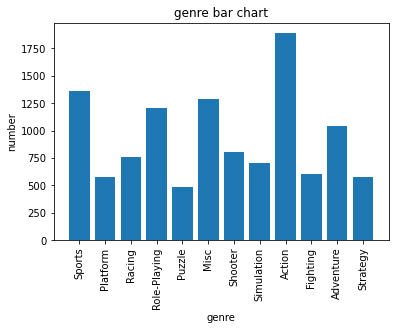

In [112]:
genre = nominal_attr_statistic(data, 'Genre')
for k, v in genre.items():
    print(str(k) + ' ' + str(v))
nominal_barchart(genre, 'genre')

动作类游戏数量最多，其次是体育类、音乐类、角色扮演和冒险类游戏。

下面统计Publisher的出现频次，由于类型数量太多，在柱状图中只绘制发行游戏数量 > 100的发行商。

Nintendo 656
Microsoft Game Studios 177
Take-Two Interactive 191
Sony Computer Entertainment 611
Activision 392
Ubisoft 557
Bethesda Softworks 29
Electronic Arts 593
Sega 466
SquareSoft 46
Atari 262
505 Games 143
Capcom 262
GT Interactive 37
Konami Digital Entertainment 629
Sony Computer Entertainment Europe 11
Square Enix 150
LucasArts 38
Virgin Interactive 52
Warner Bros. Interactive Entertainment 70
Universal Interactive 13
Eidos Interactive 120
RedOctane 4
Vivendi Games 84
Enix Corporation 28
Namco Bandai Games 756
Palcom 1
Hasbro Interactive 13
THQ 391
Fox Interactive 8
Acclaim Entertainment 114
MTV Games 12
Disney Interactive Studios 107
Majesco Entertainment 79
Codemasters 76
Red Orb 2
Level 5 24
Midway Games 99
JVC 8
Deep Silver 69
989 Studios 14
NCSoft 6
UEP Systems 1
Maxis 1
Imagic 4
Tecmo Koei 246
Valve Software 1
ASCII Entertainment 19
Mindscape 28
Infogrames 46
Arena Entertainment 1
Unknown 82
Square 6
Activision Value 11
Banpresto 71
D3Publisher 130
Oxygen Interactive 17


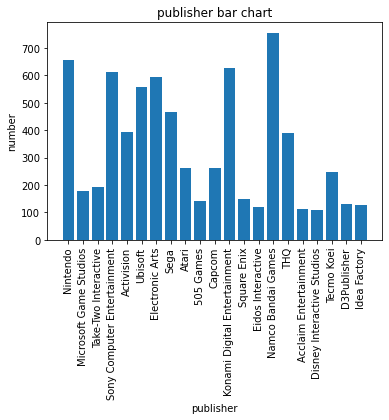

In [113]:
publisher = nominal_attr_statistic(data, 'Publisher')
for k, v in publisher.items():
    print(str(k) + ' ' + str(v))
nominal_barchart(publisher, 'publisher', 100)

下面计算五个数值属性的五数概括，并绘制盒图

count    11293.000000
mean         0.384092
std          1.179863
min          0.000000
25%          0.000000
50%          0.070000
75%          0.300000
max         41.490000
Name: NA_Sales, dtype: float64


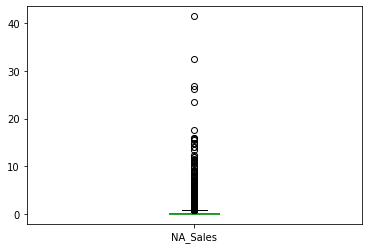

In [114]:
na_sales = data['NA_Sales'].describe()
print(na_sales)
data['NA_Sales'].plot.box()

count    11293.000000
mean         0.213630
std          0.767858
min          0.000000
25%          0.000000
50%          0.020000
75%          0.130000
max         29.020000
Name: EU_Sales, dtype: float64


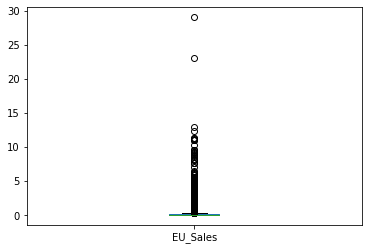

In [115]:
eu_sales = data['EU_Sales'].describe()
print(eu_sales)
data['EU_Sales'].plot.box()

count    11293.000000
mean         0.113814
std          0.389524
min          0.000000
25%          0.000000
50%          0.000000
75%          0.070000
max         10.220000
Name: JP_Sales, dtype: float64


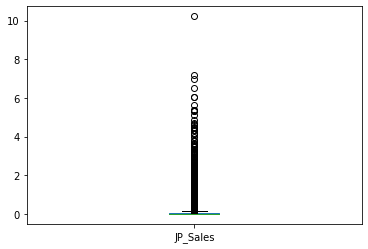

In [116]:
jp_sales = data['JP_Sales'].describe()
print(jp_sales)
data['JP_Sales'].plot.box()

count    11293.000000
mean         0.070025
std          0.276075
min          0.000000
25%          0.000000
50%          0.010000
75%          0.040000
max         10.720000
Name: Other_Sales, dtype: float64


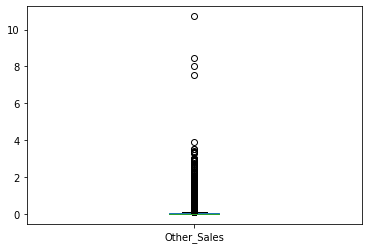

In [117]:
other_sales = data['Other_Sales'].describe()
print(other_sales)
data['Other_Sales'].plot.box()

count    11293.000000
mean         0.781956
std          2.256705
min          0.010000
25%          0.060000
50%          0.190000
75%          0.620000
max         82.740000
Name: Global_Sales, dtype: float64


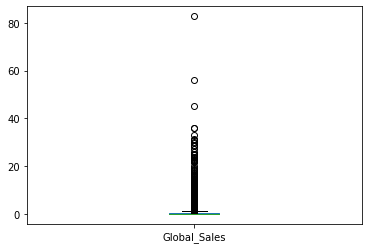

In [118]:
global_sales = data['Global_Sales'].describe()
print(global_sales)
data['Global_Sales'].plot.box()

#### 1.3数据随时间的变化关系
上面的数据描述没有用到时间属性，下面使用折线图表示各项属性随时间的变化趋势。

首先绘制5种数值属性随时间的变化折线图。

In [119]:
# 销售量随时间变化
year2sales = {}
for i in range(len(data)):
    if int(data.loc[i, 'Year']) in year2sales:
        year2sales[int(data.loc[i, 'Year'])][0] += data.loc[i, 'NA_Sales']
        year2sales[int(data.loc[i, 'Year'])][1] += data.loc[i, 'EU_Sales']
        year2sales[int(data.loc[i, 'Year'])][2] += data.loc[i, 'JP_Sales']
        year2sales[int(data.loc[i, 'Year'])][3] += data.loc[i, 'Other_Sales']
        year2sales[int(data.loc[i, 'Year'])][4] += data.loc[i, 'Global_Sales']
    else:
        year2sales[int(data.loc[i, 'Year'])] = [data.loc[i, 'NA_Sales'], data.loc[i, 'EU_Sales'], data.loc[i, 'JP_Sales'], data.loc[i, 'Other_Sales'], data.loc[i, 'Global_Sales']]
sales_pd = pd.DataFrame(year2sales.values(), index = year2sales.keys(), columns=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'])
sales_pd.sort_index(inplace = True)
print(sales_pd)

      NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
1980     11.41      1.46      0.00         0.26         13.16
1981     29.47      1.96      0.00         0.31         31.83
1982     24.68      1.58      1.26         0.29         27.81
1983     10.17      1.14      7.91         0.19         19.40
1984     34.59      2.65     15.26         0.76         53.27
1985     37.37      6.06     14.34         1.16         58.92
1986     13.38      2.96     19.88         1.98         38.21
1987      8.02      1.39     12.14         0.20         21.78
1988     23.47      6.93     14.48         1.05         45.92
1989     50.92      9.80     19.57         1.79         82.09
1990     26.05      8.14     12.92         1.49         48.60
1991     15.41      5.55     16.19         1.62         38.78
1992     35.08     12.16     31.89         1.85         81.00
1993     15.14      4.66     25.33         0.89         46.01
1994     36.91     18.57     36.93         3.02         95.42
1995    

根据刚刚计算出的时间与销量的对应关系，绘制折线图。

<Figure size 432x288 with 0 Axes>

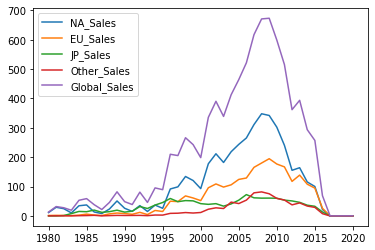

In [120]:
sales_pd.cumsum()
plt.figure()
sales_pd.plot()

可以看出，在2003-2009年间，全球的游戏销量迅速增长，其中北美和欧洲的销量增长同样迅速，但日本和其它地区的游戏销量增长不明显。在2009年之后，游戏销量逐渐下降。

下面计算三种标称属性（Platform，Genre，Publisher）的每一种属性值随时间的变化，绘制折现图实现可视化。这里只选取三种属性出现频次最高的属性值进行分析，Platform属性分析并展示PS2随时间的变化关系，Genre属性计算Action随时间的变化关系，对于Publisher属性计算Namco Bandai Games随时间的变化。

      Platform--PS2
2000             77
2001            177
2002            269
2003            248
2004            251
2005            234
2006            228
2007            171
2008            113
2009             44
2010             18
2011              1


<Figure size 432x288 with 0 Axes>

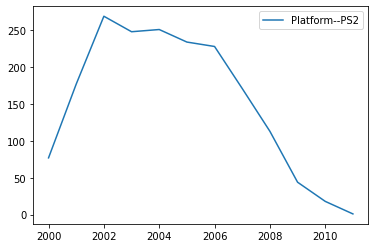

In [121]:
# 平台、类型、发行商随时间的变化
year2sales.clear()
for i in range(len(data)):
    if data.loc[i, 'Platform'] == 'PS2':
        if int(data.loc[i, 'Year']) in year2sales:
            year2sales[int(data.loc[i, 'Year'])] += 1
        else:
            year2sales[int(data.loc[i, 'Year'])] = 1
platform_pd = pd.DataFrame(year2sales.values(), index = year2sales.keys(), columns = ['Platform--PS2'])
platform_pd.sort_index(inplace = True)
print(platform_pd)
platform_pd.cumsum()
plt.figure()
platform_pd.plot()

PS2平台的游戏销量在2000-2002年逐渐增长，在2002年销量达到顶点。之后销量呈下降趋势

      Genre--Action
1980              1
1981             23
1982             18
1983              7
1984              1
1985              2
1986              6
1987              1
1988              2
1989              2
1990              3
1991              5
1992              1
1993              6
1994              4
1995              7
1996             18
1997             27
1998             38
1999             35
2000             36
2001             60
2002             87
2003             77
2004             76
2005            103
2006            125
2007            112
2008            115
2009            135
2010            118
2011            119
2012            170
2013             67
2014             76
2015            138
2016             66
2017              1


<Figure size 432x288 with 0 Axes>

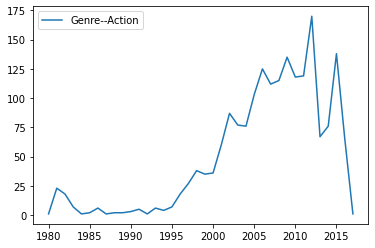

In [122]:
year2sales.clear()
for i in range(len(data)):
    if data.loc[i, 'Genre'] == 'Action':
        if int(data.loc[i, 'Year']) in year2sales:
            year2sales[int(data.loc[i, 'Year'])] += 1
        else:
            year2sales[int(data.loc[i, 'Year'])] = 1
genre_pd = pd.DataFrame(year2sales.values(), index = year2sales.keys(), columns = ['Genre--Action'])
genre_pd.sort_index(inplace = True)
print(genre_pd)
genre_pd.cumsum()
plt.figure()
genre_pd.plot()

Action类游戏销量波动较大，在2011年之前总体呈上升趋势。

      Publisher--Namco Bandai Games
1984                              2
1985                              1
1986                              2
1987                              2
1988                              2
1989                              1
1990                              2
1991                              3
1992                              2
1993                              8
1994                              6
1995                              8
1996                              8
1997                             13
1998                              9
1999                             13
2000                             13
2001                             11
2002                             22
2003                             15
2004                             23
2005                             29
2006                             59
2007                             46
2008                             46
2009                             55
2010                        

<Figure size 432x288 with 0 Axes>

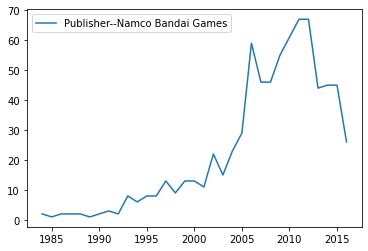

In [123]:
year2sales.clear()
for i in range(len(data)):
    if data.loc[i, 'Publisher'] == 'Namco Bandai Games':
        if int(data.loc[i, 'Year']) in year2sales:
            year2sales[int(data.loc[i, 'Year'])] += 1
        else:
            year2sales[int(data.loc[i, 'Year'])] = 1
publisher_pd = pd.DataFrame(year2sales.values(), index = year2sales.keys(), columns = ['Publisher--Namco Bandai Games'])
publisher_pd.sort_index(inplace = True)
print(publisher_pd)
publisher_pd.cumsum()
plt.figure()
publisher_pd.plot()

Namco Bandai Games发行的游戏销量在2012之前总体呈上升趋势，之后开始下降。

#### 1.3 最受欢迎的游戏平台、类型、发行商
分别按照年份统计销量最高的游戏平台、类型和发行商。

In [124]:
# 销量最高的类型，平台，发行商
def most_sale(data, attr):
    res = {}
    year_attr_sale = {}
    for i in range(len(data)):
        year = int(data.loc[i, 'Year'])
        val = data.loc[i, attr]
        if year in year_attr_sale:
            if val in year_attr_sale[year]:
                year_attr_sale[year][val] += 1
            else:
                year_attr_sale[year][val] = 1
        else:
            year_attr_sale[year] = {}
            year_attr_sale[year][val] = 1
    for k, v in year_attr_sale.items():
        t = max(v, key = v.get)
        res[k] = t
    return res

most = most_sale(data, 'Platform')
print('每年销量最高的游戏平台为：')
for i in sorted(most):
    print(i, most[i])

每年销量最高的游戏平台为：
1980 2600
1981 2600
1982 2600
1983 2600
1984 NES
1985 NES
1986 NES
1987 NES
1988 NES
1989 GB
1990 NES
1991 SNES
1992 SNES
1993 SNES
1994 SNES
1995 PS
1996 PS
1997 PS
1998 PS
1999 PS
2000 PS
2001 PS2
2002 PS2
2003 PS2
2004 PS2
2005 PS2
2006 PS2
2007 DS
2008 DS
2009 DS
2010 DS
2011 PS3
2012 PS3
2013 PS3
2014 PSV
2015 PS4
2016 PS4
2017 PS4
2020 DS


In [125]:
most = most_sale(data, 'Genre')
print('每年销量最高的游戏类型为：')
for i in sorted(most):
    print(i, most[i])

每年销量最高的游戏类型为：
1980 Misc
1981 Action
1982 Action
1983 Action
1984 Shooter
1985 Platform
1986 Action
1987 Sports
1988 Platform
1989 Puzzle
1990 Platform
1991 Sports
1992 Platform
1993 Platform
1994 Fighting
1995 Shooter
1996 Sports
1997 Sports
1998 Sports
1999 Sports
2000 Sports
2001 Sports
2002 Sports
2003 Action
2004 Action
2005 Action
2006 Action
2007 Misc
2008 Misc
2009 Misc
2010 Misc
2011 Misc
2012 Action
2013 Action
2014 Action
2015 Action
2016 Action
2017 Role-Playing
2020 Simulation


In [126]:
most = most_sale(data, 'Publisher')
print('每年销量最高的游戏发行商为：')
for i in sorted(most):
    print(i, most[i])

每年销量最高的游戏发行商为：
1980 Atari
1981 Atari
1982 Atari
1983 Atari
1984 Nintendo
1985 Nintendo
1986 Nintendo
1987 Nintendo
1988 Nintendo
1989 Nintendo
1990 Nintendo
1991 Nintendo
1992 Nintendo
1993 Nintendo
1994 Sega
1995 Sony Computer Entertainment
1996 Sony Computer Entertainment
1997 Sony Computer Entertainment
1998 Sony Computer Entertainment
1999 Konami Digital Entertainment
2000 Konami Digital Entertainment
2001 Konami Digital Entertainment
2002 Electronic Arts
2003 THQ
2004 Nintendo
2005 Electronic Arts
2006 Namco Bandai Games
2007 Konami Digital Entertainment
2008 Ubisoft
2009 Ubisoft
2010 Namco Bandai Games
2011 Namco Bandai Games
2012 Namco Bandai Games
2013 Namco Bandai Games
2014 Namco Bandai Games
2015 Namco Bandai Games
2016 Namco Bandai Games
2017 Sega
2020 Ubisoft


### 2. 游戏销量的预测
使用Platform，Genre，Publisher三种属性预测游戏的全球销量。使用Catboost回归模型进行预测。Catboost模型是集成学习的梯度提升决策树模型，将多个回归树的预测结果整合得到最终预测结果，Catboost库有较好的特征处理能力和性能。

首先将数据集按照8:1:1的比例分为训练集、验证集、测试集。分别提取四个属性作为特征和全球销量作为标签。使用均方误差作为评价指标。

In [205]:
# 提取数据
n = len(data) * 0.8
m = len(data) * 0.9
train_feature = data.loc[: n, ['Platform', 'Genre', 'Publisher', 'Year']]
train_label = data.loc[: n, 'Global_Sales']
eval_feature = data.loc[n : m, ['Platform', 'Genre', 'Publisher', 'Year']]
eval_label = data.loc[n : m, 'Global_Sales']
test_feature = data.loc[m:, ['Platform', 'Genre', 'Publisher', 'Year']]
test_label = data.loc[m:, 'Global_Sales']
# 训练模型
model = CatBoostRegressor(iterations = 100, learning_rate = 0.05, task_type = 'GPU', loss_function = 'RMSE')
cat_features = list(range(0, 3))
model.fit(train_feature, y = train_label, cat_features = cat_features, eval_set=(eval_feature, eval_label), verbose = 10)

0:	learn: 2.4741363	test: 0.9138973	best: 0.9138973 (0)	total: 10.5ms	remaining: 1.04s
10:	learn: 2.3810673	test: 0.7732471	best: 0.7732471 (10)	total: 103ms	remaining: 830ms
20:	learn: 2.3187750	test: 0.6931938	best: 0.6931938 (20)	total: 192ms	remaining: 721ms
30:	learn: 2.2919566	test: 0.6500948	best: 0.6500948 (30)	total: 288ms	remaining: 642ms
40:	learn: 2.2703909	test: 0.6251183	best: 0.6251183 (40)	total: 379ms	remaining: 545ms
50:	learn: 2.2516028	test: 0.6107542	best: 0.6107542 (50)	total: 467ms	remaining: 449ms
60:	learn: 2.2400012	test: 0.6028530	best: 0.6028530 (60)	total: 563ms	remaining: 360ms
70:	learn: 2.2315327	test: 0.5954471	best: 0.5954471 (70)	total: 652ms	remaining: 266ms
80:	learn: 2.2198609	test: 0.5918699	best: 0.5918699 (80)	total: 741ms	remaining: 174ms
90:	learn: 2.2130451	test: 0.5927857	best: 0.5918151 (81)	total: 840ms	remaining: 83ms
99:	learn: 2.2043307	test: 0.5908689	best: 0.5908689 (99)	total: 921ms	remaining: 0us
bestTest = 0.5908689088
bestIteratio

在验证集上的RMSE为0.590，之后在测试集上对全球销量进行预测，并计算RMSE。

In [206]:
# 测试模型
predict = model.predict(test_feature, prediction_type = 'RawFormulaVal', ntree_start = 0, ntree_end = model.get_best_iteration())
print(predict)

[0.4731154  0.2103269  0.64087484 ... 0.22117857 0.28516374 0.15230037]


In [207]:
# 计算RMSE
test_label.reset_index(drop = True, inplace = True)
total = 0
for i in range(len(predict)):
    total += (predict[i] - test_label[i]) * (predict[i] - test_label[i])
print('RMSE = ', math.sqrt(total/len(predict)))

RMSE =  0.4818986903781591


下面尝试增加特征以提高预测的精度。首先加入与全球销量相关性最小的JP_Sales特征。重新提取训练集、验证集、测试集并训练模型

In [208]:
train_feature = data.loc[: n, ['Platform', 'Genre', 'Publisher', 'JP_Sales', 'Year']]
train_label = data.loc[: n, 'Global_Sales']
eval_feature = data.loc[n : m, ['Platform', 'Genre', 'Publisher', 'JP_Sales', 'Year']]
eval_label = data.loc[n : m, 'Global_Sales']
test_feature = data.loc[m:, ['Platform', 'Genre', 'Publisher', 'JP_Sales', 'Year']]
test_label = data.loc[m:, 'Global_Sales']
# 训练模型
model = CatBoostRegressor(iterations = 100, learning_rate = 0.05, task_type = 'GPU', loss_function = 'RMSE')
cat_features = list(range(0, 3))
model.fit(train_feature, y = train_label, cat_features = cat_features, eval_set=(eval_feature, eval_label), verbose = 10)
# 测试模型
predict = model.predict(test_feature, prediction_type = 'RawFormulaVal', ntree_start = 0, ntree_end = model.get_best_iteration())
# 计算RMSE
test_label.reset_index(drop = True, inplace = True)
total = 0
for i in range(len(predict)):
    total += (predict[i] - test_label[i]) * (predict[i] - test_label[i])
print('RMSE = ', math.sqrt(total/len(predict)))

0:	learn: 2.4523305	test: 0.9132508	best: 0.9132508 (0)	total: 12.2ms	remaining: 1.21s
10:	learn: 2.1881584	test: 0.7749976	best: 0.7749976 (10)	total: 112ms	remaining: 906ms
20:	learn: 2.0168873	test: 0.6809822	best: 0.6809822 (20)	total: 208ms	remaining: 784ms
30:	learn: 1.8929912	test: 0.6251852	best: 0.6251852 (30)	total: 305ms	remaining: 680ms
40:	learn: 1.8144340	test: 0.5883562	best: 0.5883562 (40)	total: 403ms	remaining: 580ms
50:	learn: 1.7497266	test: 0.5605560	best: 0.5605560 (50)	total: 503ms	remaining: 483ms
60:	learn: 1.7072814	test: 0.5469756	best: 0.5467280 (58)	total: 602ms	remaining: 385ms
70:	learn: 1.6741762	test: 0.5349982	best: 0.5349982 (70)	total: 705ms	remaining: 288ms
80:	learn: 1.6320685	test: 0.5165783	best: 0.5165783 (80)	total: 810ms	remaining: 190ms
90:	learn: 1.6000545	test: 0.5092918	best: 0.5087557 (88)	total: 912ms	remaining: 90.2ms
99:	learn: 1.5647377	test: 0.4983048	best: 0.4983048 (99)	total: 1s	remaining: 0us
bestTest = 0.4983048199
bestIteration

加入JP_Sales特征后在验证集上的RMSE减小为0.493，在测试集上的RMSE减小为0.464，说明加入这一特征后有助于对于全球销量的预测。

与全球销量最相关的是NA_Sales，使用这一特征替换刚才加入的JP_Sales，再次训练模型。

In [209]:
train_feature = data.loc[: n, ['Platform', 'Genre', 'Publisher', 'NA_Sales', 'Year']]
train_label = data.loc[: n, 'Global_Sales']
eval_feature = data.loc[n : m, ['Platform', 'Genre', 'Publisher', 'NA_Sales', 'Year']]
eval_label = data.loc[n : m, 'Global_Sales']
test_feature = data.loc[m:, ['Platform', 'Genre', 'Publisher', 'NA_Sales', 'Year']]
test_label = data.loc[m:, 'Global_Sales']
# 训练模型
model = CatBoostRegressor(iterations = 100, learning_rate = 0.05, task_type = 'GPU', loss_function = 'RMSE')
cat_features = list(range(0, 3))
model.fit(train_feature, y = train_label, cat_features = cat_features, eval_set=(eval_feature, eval_label), verbose = 10)
# 测试模型
predict = model.predict(test_feature, prediction_type = 'RawFormulaVal', ntree_start = 0, ntree_end = model.get_best_iteration())
# 计算RMSE
test_label.reset_index(drop = True, inplace = True)
total = 0
for i in range(len(predict)):
    total += (predict[i] - test_label[i]) * (predict[i] - test_label[i])
print('RMSE = ', math.sqrt(total/len(predict)))

0:	learn: 2.4256433	test: 0.9131997	best: 0.9131997 (0)	total: 11.4ms	remaining: 1.13s
10:	learn: 1.7683201	test: 0.6696868	best: 0.6696868 (10)	total: 115ms	remaining: 928ms
20:	learn: 1.3645476	test: 0.5191545	best: 0.5191545 (20)	total: 212ms	remaining: 796ms
30:	learn: 1.1263641	test: 0.4284745	best: 0.4284745 (30)	total: 310ms	remaining: 690ms
40:	learn: 0.9841071	test: 0.3592615	best: 0.3592615 (40)	total: 404ms	remaining: 581ms
50:	learn: 0.9036532	test: 0.3193558	best: 0.3193558 (50)	total: 504ms	remaining: 484ms
60:	learn: 0.8521168	test: 0.2938387	best: 0.2938387 (60)	total: 600ms	remaining: 383ms
70:	learn: 0.8135768	test: 0.2797451	best: 0.2797451 (70)	total: 698ms	remaining: 285ms
80:	learn: 0.7861170	test: 0.2697883	best: 0.2697883 (80)	total: 797ms	remaining: 187ms
90:	learn: 0.7626011	test: 0.2576277	best: 0.2576277 (90)	total: 899ms	remaining: 88.9ms
99:	learn: 0.7420004	test: 0.2420502	best: 0.2420502 (99)	total: 993ms	remaining: 0us
bestTest = 0.2420502362
bestIterat

在测试集上的RMSE减小为0.251，效果有了很大的提升。说明使用与预测值关联大的特征尽心训练能够得到更好的结果。

刚刚的训练集、验证集、测试集是按照全球销量的大小顺序取得的，因此训练集中数据的全球销量最大，远大于测试集中的全球销量，这种不平衡的数据可能会影响预测的精度。因此下面尝试让数据集更加平衡，再次训练模型。

In [210]:
# 每10条数据中，前8条作为训练集，第9条作为验证集，第10条作为测试集
train_feature = pd.DataFrame()
train_label = []
eval_feature = pd.DataFrame()
eval_label = []
test_feature = pd.DataFrame()
test_label = []

for i in range(len(data)):
    if i % 10 < 8: 
        train_feature = train_feature.append(data.loc[i, ['Platform', 'Genre', 'Publisher', 'Year']])
        train_label.append(data.loc[i, 'Global_Sales'])
    elif i % 10 == 8:
        eval_feature = eval_feature.append(data.loc[i, ['Platform', 'Genre', 'Publisher', 'Year']])
        eval_label.append(data.loc[i, 'Global_Sales'])
    else:
        test_feature = test_feature.append(data.loc[i, ['Platform', 'Genre', 'Publisher', 'Year']])
        test_label.append(data.loc[i, 'Global_Sales'])
print(train_label[:5])
print(test_label[:5])

[82.74, 45.31, 35.82, 33.0, 31.37]
[28.31, 20.22, 14.64, 12.14, 10.77]


In [211]:
# 训练模型
model = CatBoostRegressor(iterations = 100, learning_rate = 0.05, task_type = 'GPU', loss_function = 'RMSE')
cat_features = list(range(0, 3))
model.fit(train_feature, y = train_label, cat_features = cat_features, eval_set=(eval_feature, eval_label), verbose = 10)
# 测试模型
predict = model.predict(test_feature, prediction_type = 'RawFormulaVal', ntree_start = 0, ntree_end = model.get_best_iteration())
# 计算RMSE
total = 0
for i in range(len(predict)):
    total += (predict[i] - test_label[i]) * (predict[i] - test_label[i])
print('RMSE = ', math.sqrt(total/len(predict)))

0:	learn: 2.3158644	test: 2.0723734	best: 2.0723734 (0)	total: 11.4ms	remaining: 1.13s
10:	learn: 2.2215310	test: 1.9842225	best: 1.9842225 (10)	total: 105ms	remaining: 847ms
20:	learn: 2.1673315	test: 1.9367258	best: 1.9367258 (20)	total: 196ms	remaining: 739ms
30:	learn: 2.1317225	test: 1.9180678	best: 1.9180678 (30)	total: 291ms	remaining: 648ms
40:	learn: 2.1052260	test: 1.9043483	best: 1.9043483 (40)	total: 383ms	remaining: 552ms
50:	learn: 2.0896144	test: 1.8976991	best: 1.8971501 (49)	total: 474ms	remaining: 455ms
60:	learn: 2.0775576	test: 1.8966008	best: 1.8964252 (55)	total: 570ms	remaining: 364ms
70:	learn: 2.0649296	test: 1.8933082	best: 1.8933082 (70)	total: 661ms	remaining: 270ms
80:	learn: 2.0544988	test: 1.8920366	best: 1.8916770 (79)	total: 752ms	remaining: 176ms
90:	learn: 2.0412298	test: 1.8903565	best: 1.8903565 (90)	total: 849ms	remaining: 84ms
99:	learn: 2.0344002	test: 1.8870699	best: 1.8867154 (98)	total: 929ms	remaining: 0us
bestTest = 1.886715365
bestIteration

仍使用"Platform", "Genre", "Publisher"三个属性，在改变数据集分布后在测试集上得到的RMSE = 1.61，效果比之前更差，训练集、验证集、测试集各自的数据范围更小会使预测的结果更好。

加入NA_Sales后再次实验

In [212]:
for i in range(len(data)):
    if i % 10 < 8: 
        train_feature = train_feature.append(data.loc[i, ['Platform', 'Genre', 'Publisher', 'Year', 'NA_Sales']])
        train_label.append(data.loc[i, 'Global_Sales'])
    elif i % 10 == 8:
        eval_feature = eval_feature.append(data.loc[i, ['Platform', 'Genre', 'Publisher', 'Year', 'NA_Sales']])
        eval_label.append(data.loc[i, 'Global_Sales'])
    else:
        test_feature = test_feature.append(data.loc[i, ['Platform', 'Genre', 'Publisher', 'Year', 'NA_Sales']])
        test_label.append(data.loc[i, 'Global_Sales'])
# 训练模型
model = CatBoostRegressor(iterations = 100, learning_rate = 0.05, task_type = 'GPU', loss_function = 'RMSE')
cat_features = list(range(0, 3))
model.fit(train_feature, y = train_label, cat_features = cat_features, eval_set=(eval_feature, eval_label), verbose = 10)
# 测试模型
predict = model.predict(test_feature, prediction_type = 'RawFormulaVal', ntree_start = 0, ntree_end = model.get_best_iteration())
# 计算RMSE
total = 0
for i in range(len(predict)):
    total += (predict[i] - test_label[i]) * (predict[i] - test_label[i])
print('RMSE = ', math.sqrt(total/len(predict)))

0:	learn: 2.3011703	test: 2.0602415	best: 2.0602415 (0)	total: 11.4ms	remaining: 1.13s
10:	learn: 2.0163378	test: 1.7690317	best: 1.7690317 (10)	total: 112ms	remaining: 903ms
20:	learn: 1.8665618	test: 1.6089791	best: 1.6089791 (20)	total: 213ms	remaining: 800ms
30:	learn: 1.7893737	test: 1.5364515	best: 1.5364515 (30)	total: 317ms	remaining: 706ms
40:	learn: 1.7497487	test: 1.5057134	best: 1.5057134 (40)	total: 422ms	remaining: 608ms
50:	learn: 1.7240956	test: 1.4875426	best: 1.4875426 (50)	total: 521ms	remaining: 501ms
60:	learn: 1.7020106	test: 1.4735574	best: 1.4735574 (60)	total: 623ms	remaining: 399ms
70:	learn: 1.6894247	test: 1.4666296	best: 1.4666296 (70)	total: 721ms	remaining: 294ms
80:	learn: 1.6817689	test: 1.4633916	best: 1.4633916 (80)	total: 822ms	remaining: 193ms
90:	learn: 1.6726191	test: 1.4572822	best: 1.4572822 (90)	total: 920ms	remaining: 91ms
99:	learn: 1.6673475	test: 1.4562960	best: 1.4562960 (99)	total: 1.01s	remaining: 0us
bestTest = 1.456295961
bestIteration

在测试集上的RMSE = 1.31，同样不如之前的预测结果。